# Steering Hallucinations in Language Models: Extending the Linear Representation Hypothesis with Sparse Autoencoders and Transcoders

This notebook attempts to extract semantic 'meaning' from the top hallucination-causing features extracted from SAE_Hallucination_Interpretability.ipynb through the use of Transcoder Circuits.  It is recommended to run that notebook first to find the top features deemed to be causing hallucinations in long-context narrative cloze-style tasks (though also seemingly any cloze-style task, as demonstrated in the 'Continuity of Hallucination-Causing Features to Other Datasets' section). We theorise in that notebook that these top features capture the underlying structures rather than semantic relationships of the representation space, which we test in this notebook.

**Note**: This takes ~8 minutes to run

**Important Note**: Once the below block is done running, restart session via 'Runtime -> Restart Session' (or, if prompted by a popup window, confirm restart session, though only AFTER the code block has run).  Then, DO NOT run the below block again; instead, start the next session from the block below it.

## Environment Setup

In [2]:
!pip install sae-lens

! git clone https://github.com/jacobdunefsky/transcoder_circuits.git
! mv transcoder_circuits transcoder_circuits_tmp
! mv transcoder_circuits_tmp/* .

# install packages and download transcoders
! bash setup.sh

#add transformers==4.30.0 to requriements.

!pip install -r requirements.txt --upgrade --force-reinstall

!pip install -U "datasets>=2.14.6"

  Using cached datasets-2.21.0-py3-none-any.whl.metadata (21 kB)
  Using cached transformer_lens-2.15.0-py3-none-any.whl.metadata (12 kB)
  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
  Using cached huggingface_hub-0.30.2-py3-none-any.whl.metadata (13 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
Using cached datasets-2.21.0-py3-none-any.whl (527 kB)
Using cached transformer_lens-2.15.0-py3-none-any.whl (189 kB)
Using cached transformers-4.51.3-py3-none-any.whl (10.4 MB)
Using cached huggingface_hub-0.30.2-py3-none-any.whl (481 kB)
Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2

fatal: destination path 'transcoder_circuits' already exists and is not an empty directory.
Installing Python packages.
  Using cached transformer_lens-1.11.0-py3-none-any.whl.metadata (12 kB)
  Using cached datasets-2.12.0-py3-none-any.whl.metadata (20 kB)
  Using cached huggingface_hub-0.17.3-py3-none-any.whl.metadata (13 kB)
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
  Using cached transformers-4.51.2-py3-none-any.whl.metadata (38 kB)
  Using cached transformers-4.51.1-py3-none-any.whl.metadata (38 kB)
  Using cached transformers-4.51.0-py3-none-any.whl.metadata (38 kB)
  Using cached transformers-4.50.3-py3-none-any.whl.metadata (39 kB)
  Using cached transformers-4.50.2-py3-none-any.whl.metadata (39 kB)
  Using cached transformers-4.50.1-py3-none-any.whl.metadata (39 kB)
  Using cached transformers-4.50.0-py3-none-any.whl.metadata (39 kB)
INFO: pip is still looking at multiple

  Using cached datasets-3.5.1-py3-none-any.whl.metadata (19 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.30.2-py3-none-any.whl.metadata (13 kB)
Using cached datasets-3.5.1-py3-none-any.whl (491 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
Using cached huggingface_hub-0.30.2-py3-none-any.whl (481 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3
  Attempting uninstall: datasets
    Found existing installation: datasets 2.12.0
    Uninstalling datasets-2.12.0:
      Successfully uninstalled datasets-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This b

**Important Note**: Once the above block is done running, restart session via 'Runtime -> Restart Session' (or, if prompted by a popup window, confirm restart session, though only AFTER the above codeblock has run).  Then, DO NOT run the above block again, start the next session from the block below.

## Setup

### Imports

In [1]:
from transcoder_circuits.circuit_analysis import *
from transcoder_circuits.feature_dashboards import *
from transcoder_circuits.replacement_ctx import *
from sae_training.sparse_autoencoder import SparseAutoencoder
from transformer_lens import HookedTransformer, utils
from sae_lens import SAE

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
import torch

torch.set_grad_enabled(False)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

True
Tesla T4


### Model and Dataset Import

In [3]:
model = HookedTransformer.from_pretrained('gpt2-small')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node in

Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
# Note: Code from function tokenize_and_concatenate() in the
# [TransformerLens Library](https://github.com/TransformerLensOrg/TransformerLens/blob/main/transformer_lens/utils.py)
import einops

def tokenize_and_concatenate(
    dataset,
    tokenizer,
    streaming = False,
    max_length = 1024,
    column_name = "text",
    add_bos_token = True,
):
    """Helper function to tokenizer and concatenate a dataset of text. This converts the text to tokens, concatenates them (separated by EOS tokens) and then reshapes them into a 2D array of shape (____, sequence_length), dropping the last batch. Tokenizers are much faster if parallelised, so we chop the string into 20, feed it into the tokenizer, in parallel with padding, then remove padding at the end.

    This tokenization is useful for training language models, as it allows us to efficiently train on a large corpus of text of varying lengths (without, eg, a lot of truncation or padding). Further, for models with absolute positional encodings, this avoids privileging early tokens (eg, news articles often begin with CNN, and models may learn to use early positional encodings to predict these)

    Args:
        dataset (Dataset): The dataset to tokenize, assumed to be a HuggingFace text dataset.
        tokenizer (AutoTokenizer): The tokenizer. Assumed to have a bos_token_id and an eos_token_id.
        streaming (bool, optional): Whether the dataset is being streamed. If True, avoids using parallelism. Defaults to False.
        max_length (int, optional): The length of the context window of the sequence. Defaults to 1024.
        column_name (str, optional): The name of the text column in the dataset. Defaults to 'text'.
        add_bos_token (bool, optional): . Defaults to True.

    Returns:
        Dataset: Returns the tokenized dataset, as a dataset of tensors, with a single column called "tokens"

    Note: There is a bug when inputting very small datasets (eg, <1 batch per process) where it just outputs nothing. I'm not super sure why
    """
    for key in dataset.features:
        if key != column_name:
            dataset = dataset.remove_columns(key)

    if tokenizer.pad_token is None:
        # We add a padding token, purely to implement the tokenizer. This will be removed before inputting tokens to the model, so we do not need to increment d_vocab in the model.
        tokenizer.add_special_tokens({"pad_token": "<PAD>"})
    # Define the length to chop things up into - leaving space for a bos_token if required
    if add_bos_token:
        seq_len = max_length - 1
    else:
        seq_len = max_length

    def tokenize_function(examples):
        text = examples[column_name]
        # Concatenate it all into an enormous string, separated by eos_tokens
        full_text = tokenizer.eos_token.join(text)
        # Divide into 20 chunks of ~ equal length
        num_chunks = 20
        chunk_length = (len(full_text) - 1) // num_chunks + 1
        chunks = [
            full_text[i * chunk_length : (i + 1) * chunk_length]
            for i in range(num_chunks)
        ]
        # Tokenize the chunks in parallel. Uses NumPy because HuggingFace map doesn't want tensors returned
        tokens = tokenizer(chunks, return_tensors="np", padding=True)[
            "input_ids"
        ].flatten()
        # Drop padding tokens
        tokens = tokens[tokens != tokenizer.pad_token_id]
        num_tokens = len(tokens)
        num_batches = num_tokens // (seq_len)
        # Drop the final tokens if not enough to make a full sequence
        tokens = tokens[: seq_len * num_batches]
        tokens = einops.rearrange(
            tokens, "(batch seq) -> batch seq", batch=num_batches, seq=seq_len
        )
        if add_bos_token:
            prefix = np.full((num_batches, 1), tokenizer.bos_token_id)
            tokens = np.concatenate([prefix, tokens], axis=1)
        return {"tokens": tokens}

    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=[column_name],
    )
    #tokenized_dataset.set_format(type="torch", columns=["tokens"])
    return tokenized_dataset


In [5]:
from datasets import load_dataset

seed = 100

# Load the LAMBADA dataset in streaming mode
dataset = load_dataset('lambada', split='test', streaming=True)  # or 'validation' for dev set[1][6]

# Shuffle and process as before
dataset = dataset.shuffle(seed=seed, buffer_size=10_000)
tokenized_lambada = tokenize_and_concatenate(dataset, model.tokenizer, max_length=128, streaming=True)
tokenized_lambada = tokenized_lambada.shuffle(seed)
lambada_tokens = np.stack([x['tokens'] for x in tokenized_lambada])

lambada_tokens_torch = torch.from_numpy(lambada_tokens).cuda()


Token indices sequence length is longer than the specified maximum sequence length for this model (4168 > 1024). Running this sequence through the model will result in indexing errors


### Transcoder Import

In [6]:
import gc

transcoder_template = "./gpt-2-small-transcoders/final_sparse_autoencoder_gpt2-small_blocks.{}.ln2.hook_normalized_24576"
transcoders = []
frequencies = []
for i in range(11):
  transcoders.append(SparseAutoencoder.load_from_pretrained(f"{transcoder_template.format(i)}.pt").eval())
  frequencies.append(torch.load(f"{transcoder_template.format(i)}_log_feature_sparsity.pt"))

gc.collect()
torch.cuda.empty_cache()

## Transcoders

### Transcoder Live Feature Analysis

In [7]:
layer = 8

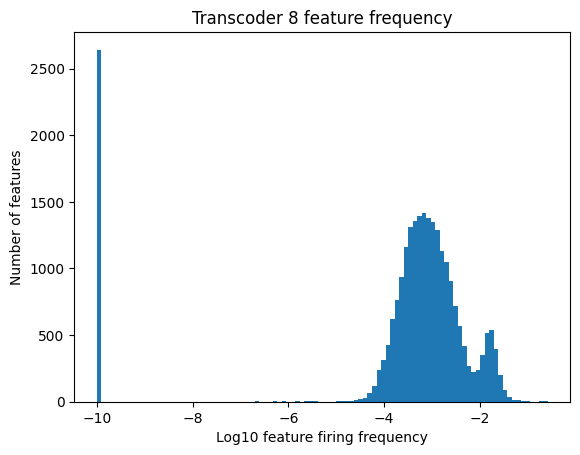

In [8]:
plt.hist(utils.to_numpy(frequencies[layer]), bins=100)
plt.xlabel("Log10 feature firing frequency")
plt.ylabel("Number of features")
plt.title("Transcoder 8 feature frequency")
plt.show()

Insert Graph Description

### Attribution Graph Example

We now ...

In [9]:
live_features = np.arange(len(frequencies[layer]))[utils.to_numpy(frequencies[layer] > -4)]

In [10]:
# Get Random Feature for Attribution Graph Example

feature_idx = live_features[77]
feature_vector = make_sae_feature_vector(transcoders[layer], feature_idx)
print(feature_vector)

mlp8tc[89]@-1


In [11]:
# Example LAMBADA prompt
prompt = "in my palm is a clear stone , and inside it is a small ivory statuette . a guardian angel . `` figured if you 're going to be out at night getting hit by cars , you might as well have some backup . '' i look at him , feeling stunned . like this is some sort of sign . but as i stare at harlin , his mouth curved in a confident grin , i do n't care about"
_, cache = model.run_with_cache(prompt) # cache the model activations on this prompt

all_paths = greedy_get_top_paths(model, transcoders, cache, feature_vector, num_iters=3, num_branches=15, do_raw_attribution=True)
print_all_paths(all_paths)

--- Paths of size 2 ---
Path [0][0]: mlp8tc[89]@-1: 0.0 <- mlp5tc[17635]@87: 0.27
Path [0][1]: mlp8tc[89]@-1: 0.0 <- attn4[11]@86: 0.25
Path [0][2]: mlp8tc[89]@-1: 0.0 <- attn3[9]@86: 0.22
Path [0][3]: mlp8tc[89]@-1: 0.0 <- mlp4tc[22814]@87: 0.2
Path [0][4]: mlp8tc[89]@-1: 0.0 <- attn3[3]@86: 0.15
Path [0][5]: mlp8tc[89]@-1: 0.0 <- attn5[11]@87: 0.14
Path [0][6]: mlp8tc[89]@-1: 0.0 <- attn3[2]@86: 0.14
Path [0][7]: mlp8tc[89]@-1: 0.0 <- attn2[8]@86: 0.14
Path [0][8]: mlp8tc[89]@-1: 0.0 <- mlp6tc[6109]@87: 0.14
Path [0][9]: mlp8tc[89]@-1: 0.0 <- attn0[1]@87: 0.13
Path [0][10]: mlp8tc[89]@-1: 0.0 <- attn7[3]@82: 0.12
Path [0][11]: mlp8tc[89]@-1: 0.0 <- attn0[4]@86: 0.098
Path [0][12]: mlp8tc[89]@-1: 0.0 <- mlp0tc[1065]@87: 0.089
Path [0][13]: mlp8tc[89]@-1: 0.0 <- mlp0tc[5175]@87: 0.085
Path [0][14]: mlp8tc[89]@-1: 0.0 <- attn3[8]@87: 0.08
--- Paths of size 3 ---
Path [1][0]: mlp8tc[89]@-1: 0.0 <- mlp0tc[5175]@87: 0.085 <- embed0@87: 0.15
Path [1][1]: mlp8tc[89]@-1: 0.0 <- mlp0tc[5175]@8

In [12]:
# ignore paths that go through MLP2 transcoder
filtered_paths = get_paths_via_filter(all_paths, not_infix_path=[
    FeatureFilter(
        layer=2, layer_filter_type=FilterType.EQ,
        feature_type=FeatureType.TRANSCODER
    )
])

# ignore paths that end in last token
filtered_paths = get_paths_via_filter(filtered_paths, suffix_path=[
    FeatureFilter(token=9, token_filter_type=FilterType.NE)
])

# look at paths that end in layer 0
filtered_paths = get_paths_via_filter(filtered_paths, suffix_path=[
    FeatureFilter(layer=0)
])

print_all_paths(filtered_paths)

Path [0]: mlp8tc[89]@-1: 0.0 <- attn0[1]@87: 0.13
Path [1]: mlp8tc[89]@-1: 0.0 <- attn0[4]@86: 0.098
Path [2]: mlp8tc[89]@-1: 0.0 <- mlp0tc[1065]@87: 0.089
Path [3]: mlp8tc[89]@-1: 0.0 <- mlp0tc[5175]@87: 0.085
Path [4]: mlp8tc[89]@-1: 0.0 <- mlp0tc[5175]@87: 0.085 <- embed0@87: 0.15
Path [5]: mlp8tc[89]@-1: 0.0 <- mlp0tc[5175]@87: 0.085 <- attn0[1]@87: 0.12
Path [6]: mlp8tc[89]@-1: 0.0 <- mlp0tc[1065]@87: 0.089 <- embed0@87: 0.098
Path [7]: mlp8tc[89]@-1: 0.0 <- attn2[8]@86: 0.14 <- mlp0tc[3098]@86: 0.076
Path [8]: mlp8tc[89]@-1: 0.0 <- mlp0tc[5175]@87: 0.085 <- attn0[5]@87: 0.065
Path [9]: mlp8tc[89]@-1: 0.0 <- attn3[9]@86: 0.22 <- mlp0tc[3098]@86: 0.047
Path [10]: mlp8tc[89]@-1: 0.0 <- mlp0tc[1065]@87: 0.089 <- attn0[1]@87: 0.047
Path [11]: mlp8tc[89]@-1: 0.0 <- attn3[9]@86: 0.22 <- attn0[1]@86: 0.036
Path [12]: mlp8tc[89]@-1: 0.0 <- attn2[8]@86: 0.14 <- mlp0tc[3098]@86: 0.076 <- embed0@86: 0.027
Path [13]: mlp8tc[89]@-1: 0.0 <- attn2[8]@86: 0.14 <- mlp0tc[3098]@86: 0.076 <- attn0[4

In [13]:
edges, nodes = paths_to_graph(all_paths)
edges_with_error, nodes_with_error = add_error_nodes_to_graph(model, cache, transcoders, edges, nodes)

for node, node_feature_obj in nodes_with_error.items():
    print(node, node_feature_obj.contrib)

mlp8tc[89]@-1 0.0
mlp5tc[17635]@87 0.2700384855270386
mlp4tc[22814]@87 0.30352646112442017
mlp6tc[6109]@87 0.13591702282428741
mlp0tc[1065]@87 0.08928248286247253
mlp0tc[5175]@87 0.08508705347776413
embed0@87 0.24285060912370682
mlp0tc[3098]@86 0.14138720743358135
mlp3tc[9556]@87 0.16782118938863277
embed0@86 0.04377482086420059
attn4[11]@86 0.24595041573047638
attn3[9]@86 0.2685865657404065
attn3[3]@86 0.23703904636204243
attn5[11]@87 0.14402835071086884
attn3[2]@86 0.14065669476985931
attn2[8]@86 0.13906754553318024
attn0[1]@87 0.30007535964250565
attn7[3]@82 0.12065623700618744
attn0[4]@86 0.1343744220212102
attn3[8]@87 0.08038222044706345
attn0[5]@87 0.06505932658910751
attn0[1]@86 0.05540705658495426
attn0[5]@86 0.017747508361935616
attn0[3]@86 0.016576528549194336
attn2[4]@86 0.029075581580400467
mlp8tc[89]tc_error8@-1 -0.07742049731314182
mlp0tc[5175]tc_error0@87 0.0
mlp0tc[1065]tc_error0@87 0.0
attn2[8]tc_error2@86 0.012353611644357443
attn5[11]tc_error5@87 0.032914350274950266

Using something, we something

In [14]:
plot_graph(edges_with_error, nodes_with_error)

As seen above, something

### Feature Ranking

First we would like to figure out what layer 8 features are most likley to produce a hallucination. Then we use the attribution circuit to figure out the de embedings of the most important combination of layer 0 features.

In [15]:
def cache_lambada_two_pass_streaming_contrastive(model, tokens, transcoder, live_features, layer=8, batch_size=8, top_k=20):
    """Two-pass streaming algorithm for contrastive feature activation analysis
    Accumulates statistics in a streaming fashion to reduce memory usage.
    """
    import torch
    from tqdm import tqdm
    import gc

    device = next(model.parameters()).device
    hook_point = f"blocks.{layer}.ln2.hook_normalized"
    n_features = len(live_features)

    # --- Accumulate statistics for contrastive ranking ---
    print("Accumulating statistics for contrastive ranking...")

    # Statistics trackers
    sum_halluc_acts = torch.zeros(n_features, device='cpu')
    sum_correct_acts = torch.zeros(n_features, device='cpu')
    count_halluc = 0
    count_correct = 0

    for i in tqdm(range(0, len(tokens), batch_size), desc="Processing batches"):
        batch = torch.tensor(tokens[i:i+batch_size]).to(device)

        with torch.no_grad():
            # Get model outputs
            logits, cache = model.run_with_cache(batch, names_filter=lambda name: name == hook_point)
            acts = cache[hook_point].clone()
            del cache

            # Calculate hallucination mask
            targets = batch[:, -1]
            preds = torch.argmax(logits[:, -2, :], dim=-1)
            batch_hallu_mask = (preds != targets).cpu()
            del logits

            # Process activations
            flat_acts = acts.reshape(-1, acts.shape[-1])
            features = transcoder(flat_acts)[1][:, live_features]
            del acts, flat_acts

            # Reshape and convert to CPU
            features = features.reshape(batch.size(0), -1, n_features).cpu()

            # Update statistics based on hallucination mask
            for j in range(batch.size(0)):
                if batch_hallu_mask[j]:
                    sum_halluc_acts += features[j].sum(dim=0)
                    count_halluc += features[j].shape[0]
                else:
                    sum_correct_acts += features[j].sum(dim=0)
                    count_correct += features[j].shape[0]

            # Cleanup
            del features, batch_hallu_mask
            torch.cuda.empty_cache()
            gc.collect()

    # Calculate mean activations
    mean_halluc_acts = sum_halluc_acts / count_halluc
    mean_correct_acts = sum_correct_acts / count_correct

    # Contrastive score: hallucination-specific activation
    contrast_score = mean_halluc_acts - mean_correct_acts

    # Top-k by contrast score
    top_indices = torch.topk(contrast_score, k=top_k).indices.cpu().numpy()

    return top_indices

In [16]:
top_k = 20
top_features = cache_lambada_two_pass_streaming_contrastive(model,
                                                           lambada_tokens_torch,
                                                           transcoders[layer],
                                                           live_features,
                                                           layer=layer,
                                                           batch_size=8,
                                                           top_k=top_k
                                                           )

Accumulating statistics for contrastive ranking...


Processing batches:   0%|          | 0/413 [00:00<?, ?it/s]<ipython-input-15-99de2db6c7ba>:23: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Processing batches: 100%|██████████| 413/413 [02:54<00:00,  2.37it/s]


In [17]:
print(top_features)

[15684 15627 17530  8739 20221  5695 17695 20939 19272   748  9983 11210
  6611  5633   726  4949  4498  4073  6656  9915]


**Note**: These top feature indices may not be the same as those printed in SAE_Hallucination_Interpretability.ipynb.  This is likely due to the Transcoder using a different decoding matrix than the SAE, meaning the same feature may have different indices in Transcoder and SAE decoder matrices.

### Feature Interpretation

We first display the most positive and negative de-embedding tokens for each of the top_k top features, then display each feature's activation heatmap on different prompts

In [18]:
for feature_analysing in top_features:
  print(f'De-embeddings for Feature {feature_analysing}:')
  display_deembeddings_for_feature_vector(model, make_sae_feature_vector(transcoders[layer], feature_analysing))
  print('\n')

De-embeddings for Feature 15684:




De-embeddings for Feature 15627:




De-embeddings for Feature 17530:




De-embeddings for Feature 8739:




De-embeddings for Feature 20221:




De-embeddings for Feature 5695:




De-embeddings for Feature 17695:




De-embeddings for Feature 20939:




De-embeddings for Feature 19272:




De-embeddings for Feature 748:




De-embeddings for Feature 9983:




De-embeddings for Feature 11210:




De-embeddings for Feature 6611:




De-embeddings for Feature 5633:




De-embeddings for Feature 726:




De-embeddings for Feature 4949:




De-embeddings for Feature 4498:




De-embeddings for Feature 4073:




De-embeddings for Feature 6656:




De-embeddings for Feature 9915:


**Note**: This code takes ~10 minutes to run

In [19]:
for idx in range(len(top_features)):

  feature_analysing = top_features[idx]

  print(f'Activating Examples for Feature {feature_analysing} (Index {idx}):')

  # Get scores with NaN checking
  cur_scores = get_feature_scores(model, transcoders[layer], lambada_tokens_torch, feature_analysing, batch_size=128)
  # Convert scores to tensor first
  cur_scores_tensor = torch.from_numpy(cur_scores).float().cuda()

  # Now check NaNs
  print('\n')

  nan_vals = torch.isnan(cur_scores_tensor).sum().item()
  min_val = torch.min(cur_scores_tensor).item()
  max_val = torch.max(cur_scores_tensor).item()
  mean_val = torch.mean(cur_scores_tensor).item()

  print("NaN values:", nan_vals)
  print("Min:", min_val,
        "Max:", max_val,
        "Mean:", mean_val)

  if nan_vals == 0 and min_val == 0 and max_val == 0 and mean_val == 0:
    print('\n')
    print("Error calculating activations")
    print('\n')
    continue

  display_activating_examples_dash(model, lambada_tokens_torch, cur_scores, header_level=None) # don't show dashboard with html headers

  print('\n')

  del cur_scores_tensor
  del cur_scores
  gc.collect()
  torch.cuda.empty_cache()


Activating Examples for Feature 15684 (Index 0):


100%|██████████| 26/26 [00:30<00:00,  1.16s/it]



NaN values: 0
Min: 0.0 Max: 9.734375 Mean: 0.304935485124588




Activating Examples for Feature 15627 (Index 1):


100%|██████████| 26/26 [00:29<00:00,  1.14s/it]



NaN values: 0
Min: 0.0 Max: 6.8125 Mean: 0.0003588105028029531




Activating Examples for Feature 17530 (Index 2):


100%|██████████| 26/26 [00:29<00:00,  1.14s/it]



NaN values: 0
Min: 0.0 Max: 6.6171875 Mean: 0.011309073306620121




Activating Examples for Feature 8739 (Index 3):


100%|██████████| 26/26 [00:29<00:00,  1.15s/it]



NaN values: 0
Min: 0.0 Max: 10.6328125 Mean: 0.002603225177153945




Activating Examples for Feature 20221 (Index 4):


100%|██████████| 26/26 [00:29<00:00,  1.14s/it]



NaN values: 0
Min: 0.0 Max: 8.1484375 Mean: 0.0003561351913958788




Activating Examples for Feature 5695 (Index 5):


100%|██████████| 26/26 [00:29<00:00,  1.14s/it]



NaN values: 0
Min: 0.0 Max: 9.171875 Mean: 0.0009136159205809236




Activating Examples for Feature 17695 (Index 6):


100%|██████████| 26/26 [00:29<00:00,  1.15s/it]



NaN values: 0
Min: 0.0 Max: 4.25390625 Mean: 0.013508806005120277




Activating Examples for Feature 20939 (Index 7):


100%|██████████| 26/26 [00:29<00:00,  1.15s/it]



NaN values: 0
Min: 0.0 Max: 3.6328125 Mean: 0.0022695756051689386




Activating Examples for Feature 19272 (Index 8):


100%|██████████| 26/26 [00:29<00:00,  1.15s/it]




NaN values: 0
Min: 0.0 Max: 0.0 Mean: 0.0


Error calculating activations


Activating Examples for Feature 748 (Index 9):


100%|██████████| 26/26 [00:29<00:00,  1.15s/it]



NaN values: 0
Min: 0.0 Max: 11.6640625 Mean: 0.00011200993321835995




Activating Examples for Feature 9983 (Index 10):


100%|██████████| 26/26 [00:29<00:00,  1.14s/it]



NaN values: 0
Min: 0.0 Max: 4.57421875 Mean: 7.729884964646772e-05




Activating Examples for Feature 11210 (Index 11):


100%|██████████| 26/26 [00:29<00:00,  1.14s/it]



NaN values: 0
Min: 0.0 Max: 3.611328125 Mean: 6.442111771320924e-05




Activating Examples for Feature 6611 (Index 12):


100%|██████████| 26/26 [00:29<00:00,  1.15s/it]



NaN values: 0
Min: 0.0 Max: 8.109375 Mean: 0.016090909019112587




Activating Examples for Feature 5633 (Index 13):


100%|██████████| 26/26 [00:29<00:00,  1.14s/it]



NaN values: 0
Min: 0.0 Max: 11.7578125 Mean: 0.0005574858514592052




Activating Examples for Feature 726 (Index 14):


100%|██████████| 26/26 [00:29<00:00,  1.15s/it]



NaN values: 0
Min: 0.0 Max: 7.1171875 Mean: 0.0009025271865539253




Activating Examples for Feature 4949 (Index 15):


100%|██████████| 26/26 [00:29<00:00,  1.15s/it]



NaN values: 0
Min: 0.0 Max: 12.09375 Mean: 0.00092895986745134




Activating Examples for Feature 4498 (Index 16):


100%|██████████| 26/26 [00:29<00:00,  1.15s/it]



NaN values: 0
Min: 0.0 Max: 15.8671875 Mean: 0.00010052553989225999




Activating Examples for Feature 4073 (Index 17):


100%|██████████| 26/26 [00:29<00:00,  1.14s/it]



NaN values: 0
Min: 0.0 Max: 7.32421875 Mean: 0.0007372535183094442




Activating Examples for Feature 6656 (Index 18):


100%|██████████| 26/26 [00:29<00:00,  1.15s/it]




NaN values: 0
Min: 0.0 Max: 0.0 Mean: 0.0


Error calculating activations


Activating Examples for Feature 9915 (Index 19):


100%|██████████| 26/26 [00:29<00:00,  1.15s/it]



NaN values: 0
Min: 0.0 Max: 3.287109375 Mean: 0.0003881959419231862


**Remark**: By clicking the dropdown arrows above, you can see the chosen feature's activation on example prompts in the LAMBADA dataset.  Qualitatively, we see that the majority of these activation activate relatively infrequently, as well as that they typically capture some syntactic qualities of the prompt (e.g. prepositions, definite articles like 'the' or 'that', possessives like 'had' or 'have', or relative numberings ike 'fourth' or 'second').  This supports our belief that:

(1) hallucination-causing features are very context-dependent (due to their infrequent activations) and support structural signals rather than token-level semantics

(2) hallucination-causing features interact with how information is bridged and contextualised rather than what the prompt is discussing semantically (e.g. activating more on prepositions and definite articles rather than concepts or ideas like 'Golden Gate Bridge')

## Attribution Circuits

**Note**: Analysing Attribution circuits takes some time, so we pick 3 examples from the top features to analyse.  To look at another example, simply change the value of feature_analysing be changing the index of top_features being used.

In [20]:
feat_one = 15684 # top_features[0] # Feature 15684 -- appears to activate most on prepositions
feat_two = 11210 #top_features[11] # Feature 11210 -- appears to activate most on relative numbering (e.g. 'fourth', 'second')
feat_three = 5633 #top_features[13] # Feature 5633 -- appears to activate most on definite articles like 'the' or 'that'

print(f'First Feature Analysed: {feat_one}')
print(f'Second Feature Analysed: {feat_two}')
print(f'Third Feature Analysed: {feat_three}')

First Feature Analysed: 15684
Second Feature Analysed: 11210
Third Feature Analysed: 5633


### Plotting Code

We rewrite the plot_graph function from circuit_analysis.py to accept a title parameter to give our circuit/attribution graphs titles

In [21]:
# Note: Code from function plot_graph() in the
# [Transcoder Circuits Library](https://github.com/jacobdunefsky/transcoder_circuits/blob/master/transcoder_circuits/circuit_analysis.py)

def plot_graph(edges, nodes, title, y_mult=1.0, width=800, height=600, arrow_width_multiplier=3.0, only_get_contribs_in_graph=False):
    # TODO: ugly code reuse with feature_dashboard
    def batch_color_interpolate(scores, max_color, zero_color, scores_min=None, scores_max=None):
        if scores_min is None: scores_min = scores.min()
        if scores_max is None: scores_max = scores.max()
        scores_normalized = (scores - scores_min) / (scores_max - scores_min)

        max_color_vec = np.array([int(max_color[1:3], 16), int(max_color[3:5], 16), int(max_color[5:7], 16)])
        zero_color_vec = np.array([int(zero_color[1:3], 16), int(zero_color[3:5], 16), int(zero_color[5:7], 16)])

        color_vecs = np.einsum('i, j -> ij', scores_normalized, max_color_vec) + np.einsum('i, j -> ij', 1-scores_normalized, zero_color_vec)
        color_strs = [f"#{int(x[0]):02x}{int(x[1]):02x}{int(x[2]):02x}" for x in color_vecs]
        return color_strs

    arrow_widths = np.array(list(edges.values()))
    arrow_widths = 1 + arrow_width_multiplier*(arrow_widths-arrow_widths.min())/(arrow_widths.max()-arrow_widths.min())

    layout = nodes_to_coords(nodes, y_mult=y_mult)
    colors = batch_color_interpolate(np.array([x.contrib if x.contrib is not None else 0 for x in nodes.values()]), '#22ff22', '#ffffff')

    trace = go.Scatter(
        x=[val[0] for val in layout.values()],
        y=[val[1] for val in layout.values()],
        hoverinfo='text',
        hovertext=[f"{key}<br>Contrib: {val.contrib:.2}" if val.contrib is not None else f"{key}" for key, val in nodes.items()],
        mode='markers',
        marker=dict(size=20, line=dict(width=1, color='Black'), color=colors)
    )

    trace2 = go.Scatter(
        x=[(layout[edge[0]][0]+layout[edge[1]][0])/2 for edge in edges],
        y=[(layout[edge[0]][1]+layout[edge[1]][1])/2 for edge in edges],
        hoverinfo='text',
        hovertext=[f"{edge[0]} -> {edge[1]}<br>Contrib: {contrib:.2}" if contrib is not None else f"{edge[0]} -> {edge[1]}" for edge, contrib in edges.items()],
        mode='markers', marker_symbol='square',
        marker=dict(size=5, line=dict(width=1, color='Black'), color='black')
    )

    # Plot edges
    # Thank you to https://stackoverflow.com/a/51430912 for the general idea
    x0, y0, x1, y1 = [], [], [], []

    for edge in edges:
        x0.append(layout[edge[0]][0])
        y0.append(layout[edge[0]][1])
        x1.append(layout[edge[1]][0])
        y1.append(layout[edge[1]][1])

    fig = go.Figure(
        data=[trace, trace2],
        layout=go.Layout(
            autosize=False,
            width=width,
            height=height,
            showlegend=False,
            xaxis_title='Layer',
            title=title,
            annotations = [
                dict(ax=x0[i], ay=y0[i], axref='x', ayref='y',
                    x=x1[i], y=y1[i], xref='x', yref='y',
                    showarrow=True, arrowhead=1, arrowwidth=arrow_widths[i]) for i in range(0, len(x0))
            ],
            yaxis = dict(
                tickmode = 'array',
                tickvals = [],
                ticktext = []
            )
        )
    )
    fig.show()

### Attribution Circuit (One)

In [22]:
feature_idx = feat_one
feature_vector = make_sae_feature_vector(transcoders[layer], feature_idx)

cur_scores = get_feature_scores(model, transcoders[layer], lambada_tokens_torch, feature_idx, batch_size=128)

# Sum scores across tokens (axis=1) for each prompt
prompt_totals = cur_scores.sum(axis=1)  # Shape: (3300,)

# Get indices of top prompts (sorted descending)
top_indices = np.argsort(prompt_totals)[::-1]  # Full sorted order
top_5_indices = top_indices[:5]  # First 5 elements

# Retrieve actual prompts from your dataset
top_prompts = [lambada_tokens[i] for i in top_5_indices]


prompt = torch.tensor(top_prompts[0]).cuda()
_, cache = model.run_with_cache(prompt) # cache the model activations on this prompt

all_paths = greedy_get_top_paths(model, transcoders, cache, feature_vector, num_iters=3, num_branches=15, do_raw_attribution=True)

# ignore paths that end in last token
filtered_paths = get_paths_via_filter(filtered_paths, suffix_path=[
    FeatureFilter(token=9, token_filter_type=FilterType.NE)
])

# look at paths that end in layer 0
filtered_paths = get_paths_via_filter(filtered_paths, suffix_path=[
    FeatureFilter(layer=0)
])

edges, nodes = paths_to_graph(all_paths)
edges_with_error, nodes_with_error = add_error_nodes_to_graph(model, cache, transcoders, edges, nodes)

print_all_paths(all_paths)


#del all_paths, edges, nodes
#gc.collect()
#torch.cuda.empty_cache()


100%|██████████| 26/26 [00:29<00:00,  1.14s/it]


--- Paths of size 2 ---
Path [0][0]: mlp8tc[15684]@-1: 0.0 <- attn5[4]@123: 0.32
Path [0][1]: mlp8tc[15684]@-1: 0.0 <- attn8[7]@123: 0.23
Path [0][2]: mlp8tc[15684]@-1: 0.0 <- attn3[7]@127: 0.2
Path [0][3]: mlp8tc[15684]@-1: 0.0 <- embed0@127: 0.19
Path [0][4]: mlp8tc[15684]@-1: 0.0 <- attn1[0]@119: 0.18
Path [0][5]: mlp8tc[15684]@-1: 0.0 <- mlp7tc[14728]@127: 0.17
Path [0][6]: mlp8tc[15684]@-1: 0.0 <- mlp6tc[16848]@127: 0.17
Path [0][7]: mlp8tc[15684]@-1: 0.0 <- attn8[6]@87: 0.15
Path [0][8]: mlp8tc[15684]@-1: 0.0 <- attn7[9]@121: 0.15
Path [0][9]: mlp8tc[15684]@-1: 0.0 <- attn2[8]@123: 0.14
Path [0][10]: mlp8tc[15684]@-1: 0.0 <- attn8[5]@119: 0.14
Path [0][11]: mlp8tc[15684]@-1: 0.0 <- attn0[5]@127: 0.13
Path [0][12]: mlp8tc[15684]@-1: 0.0 <- attn5[2]@126: 0.13
Path [0][13]: mlp8tc[15684]@-1: 0.0 <- attn8[2]@113: 0.12
Path [0][14]: mlp8tc[15684]@-1: 0.0 <- attn6[0]@123: 0.11
--- Paths of size 3 ---
Path [1][0]: mlp8tc[15684]@-1: 0.0 <- attn1[0]@119: 0.18 <- mlp0tc[3238]@119: 0.13
Pat

In [23]:
plot_graph(edges_with_error, nodes_with_error, title = f'Attribution Graph for Feature {feature_idx}')

For analisis we pick can focus on the features with the highest contribution across the circuit. ie-

From size-2 paths:

Path [0][5]: mlp7tc[14728]@127

Path [0][6]: mlp6tc[16848]@127

From size-3 paths:

Path [1][1]: mlp3tc[18653]@123

Path [1][4]: mlp7tc[2950]@123

Path [1][5]: mlp7tc[1191]@123

Path [1][10]: mlp2tc[22678]@123

Path [1][11]: mlp5tc[9019]@127

Path [1][13]: mlp7tc[14728]@127

From size-4 paths:

Path [2][4]: mlp3tc[18653]@123

Path [2][6]: mlp2tc[22678]@123

Path [2][8]: mlp0tc[19702]@123

Path [2][9]: mlp0tc[5155]@122

Path [2][10]: mlp0tc[3766]@122



In [24]:
selected_paths = [
    (0, 5, 2, 7),   # mlp7tc
    (0, 6, 2, 6),   # mlp6tc
    (1, 0, 2, 0),   # mlp0tc
    (1, 1, 2, 3),   # mlp3tc
    (1, 4, 2, 7),   # mlp7tc
    (1, 5, 2, 7),   # mlp7tc
    (1, 10, 2, 2),  # mlp2tc
    (1, 11, 2, 5),  # mlp5tc
    (2, 0, 2, 0),   # mlp0tc
    (2, 1, 2, 0),   # mlp0tc
    (2, 2, 2, 0),   # mlp0tc
    (2, 3, 2, 0),   # mlp0tc
    (2, 4, 2, 3),   # mlp3tc
    (2, 5, 2, 0),   # mlp0tc
    (2, 6, 2, 2),   # mlp2tc
    (2, 8, 2, 0),   # mlp0tc
    (2, 9, 2, 0),   # mlp0tc
    (2, 10, 2, 0),  # mlp0tc
]

for path in selected_paths:
    a, b, c, layer = path
    path_sequence = all_paths[a][b]  # Get the full path

    parent_feature = path_sequence[0]         # First node
    final_node = path_sequence[-1]            # Final node e.g. 'mlp2tc[22678]@123'

    display_deembeddings_for_feature_vector(model, final_node)
